In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import numpy as np
import matplotlib
import math
import pprint
import seaborn as sns
from cityScraper import transformDataFrame
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial.distance import cosine
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 5.5)
df = pd.read_csv('data/SF_data_private_3.csv',delimiter=',',index_col=0);
df = transformDataFrame(df)
df = df[df.price<300]
featureList = ['amen_'+str(i)for i in range(1,51)]
featureList += ['bin_acc_rating','bin_cancel_policy','bin_checkin_rating','bin_cleanliness_rating','bin_guest_sat','bin_host_other_rev_count','bin_instant_book','bin_is_apt','bin_loc_rating','bin_num_bathrooms','bin_num_beds','bin_person_cap','bin_pic_count','bin_review_count','bin_value_rating']
featureList = sorted(featureList)
dbList = featureList+['lat','lon','price','acc_rating','cancel_policy','checkin_rating','cleanliness_rating','guest_sat','host_other_rev_count','is_apt','instant_book','loc_rating','num_bathrooms','num_beds','person_cap','pic_count','review_count','value_rating']
dbList = sorted(dbList)

/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['num_bathrooms']=temp_df['num_bathrooms'].apply(lambda x:float(str(x).strip('+')))
/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['is_apt'] = df['prop_type'].apply(lambda x: x=='Apartment')
/Users/brian/Dropbox/Insight/PricePredictor/PricePredictor/cityScraper.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [2]:
df['dist_ferry_quant'] = pd.qcut(df['dist_ferry'],q=20)

In [3]:
global_mean = df['price'].mean()
correct = lambda x : x*global_mean/x.mean()
df['corr_price']=df[['dist_ferry_quant','price']].groupby('dist_ferry_quant')['price'].transform(correct)

In [4]:
X = np.array(df[featureList])
y = np.array(df['corr_price'].astype('float'))

In [16]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

RANDOM_STATE = 123
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a Regressor name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,10):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



//anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda/envs/my_projects_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [36]:
# # Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of trees")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

NameError: name 'error_rate' is not defined

In [37]:
M_train = int(len(df.index)*0.8)
train_rows = np.random.choice(df.index.values,M_train)
df_train = df.ix[train_rows]
df_test = df.drop(train_rows)

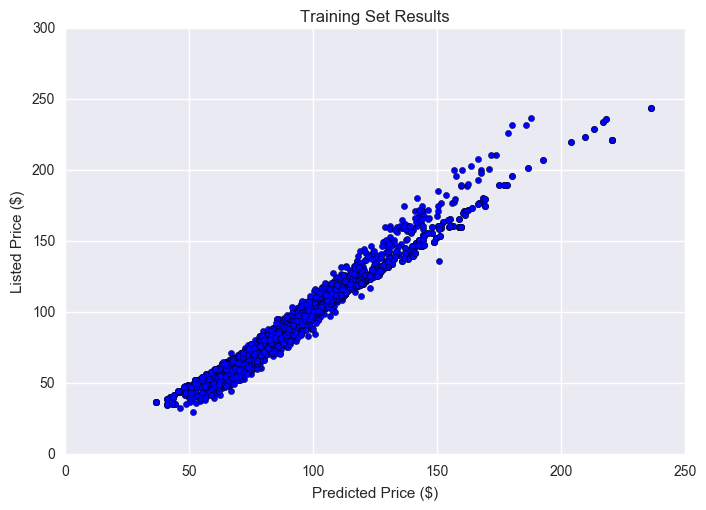

In [39]:
X = np.array(df_train[featureList])
Y = np.array(df_train['corr_price'].astype('float'))
forest=RandomForestRegressor(n_estimators=1000,max_features='log2',n_jobs=-1)
forest.fit(X,Y)
df['pred_price']=forest.predict(df[featureList])
plt.scatter(df.ix[train_rows]['pred_price'],df.ix[train_rows]['corr_price'])
plt.title('Training Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

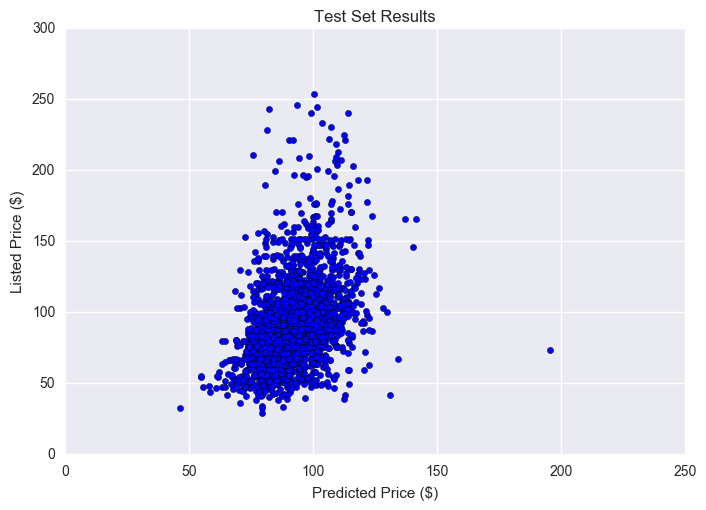

In [40]:
plt.scatter(df.drop(train_rows)['pred_price'],df.drop(train_rows)['corr_price'])
plt.title('Test Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

In [41]:
import scipy

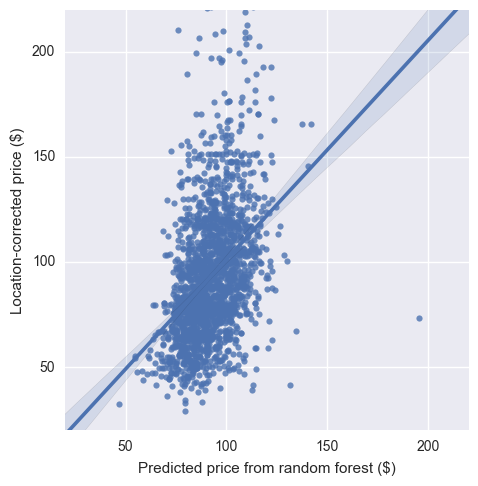

In [42]:
sns.lmplot('pred_price','corr_price',df.drop(train_rows));
plt.xlabel('Predicted price from random forest ($)')
plt.ylabel('Location-corrected price ($)')
plt.ylim([20,220])
plt.xlim([20,220]);

In [43]:
x=df.drop(train_rows)['pred_price']
y=df.drop(train_rows)['corr_price']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(slope,intercept,r_value**2,p_value,std_err)

1.04325020921 -3.05616860596 0.155376269305 4.09259427982e-75 0.0544983192054


Feature ranking:
1. bin_num_beds (0.034773)
2. bin_loc_rating (0.030518)
3. bin_host_other_rev_count (0.027771)
4. bin_person_cap (0.026554)
5. bin_cleanliness_rating (0.024877)
6. bin_guest_sat (0.024377)
7. amen_1 (0.024321)
8. bin_review_count (0.024241)
9. amen_9 (0.023579)
10. amen_2 (0.022796)
11. amen_47 (0.022382)
12. bin_cancel_policy (0.022310)
13. amen_42 (0.022180)
14. amen_3 (0.022023)
15. amen_8 (0.021683)
16. bin_is_apt (0.021558)
17. amen_39 (0.021408)
18. amen_37 (0.021285)
19. amen_43 (0.020773)
20. amen_50 (0.020452)
21. bin_instant_book (0.020202)
22. amen_36 (0.019831)
23. amen_31 (0.019807)
24. bin_value_rating (0.019740)
25. amen_46 (0.019521)
26. amen_44 (0.019433)
27. amen_34 (0.019402)
28. amen_41 (0.019258)
29. amen_33 (0.019252)
30. amen_45 (0.019088)
31. amen_49 (0.017968)
32. amen_27 (0.017303)
33. amen_16 (0.017128)
34. amen_38 (0.017080)
35. amen_17 (0.016767)
36. amen_40 (0.015788)
37. amen_30 (0.015441)
38. bin_checkin_rating (0.014850)
39. amen_5 (0.0

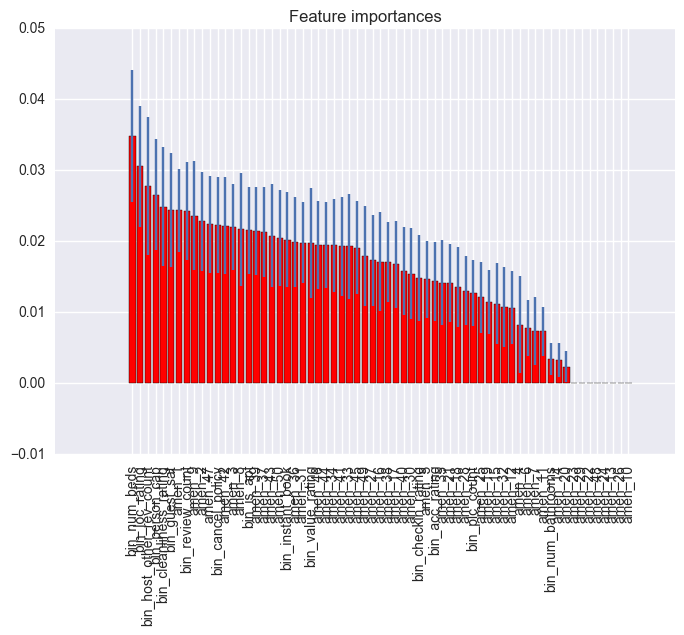

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#num_feat=20
#indices=indices[:num_feat]
# Print the feature ranking
print("Feature ranking:")
importance_dict = {}
features_20 = []
for f in range(X.shape[1]):
    print("%i. %s (%f)" % (f+1,featureList[indices[f]], importances[indices[f]]))
    importance_dict[featureList[indices[f]]] = importances[indices[f]]
    features_20.append(featureList[indices[f]])
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
      color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [featureList[i] for i in indices],rotation=90)
plt.show()

In [39]:
amen_name_dict = joblib.load('static/amen_name_dict.pkl')
pprint.pprint(amen_name_dict)

{1: 'TV',
 2: 'Cable TV',
 3: 'Internet',
 4: 'Wireless Internet',
 5: 'Air conditioning',
 6: 'Wheelchair accessible',
 7: 'Pool',
 8: 'Kitchen',
 9: 'Free parking on premises',
 10: 'Paid parking off premises',
 11: 'Smoking allowed',
 12: 'Pets allowed',
 14: 'Doorman',
 15: 'Gym',
 16: 'Breakfast',
 21: 'Elevator in building',
 23: 'Free parking on street',
 25: 'Hot tub',
 27: 'Indoor fireplace',
 28: 'Buzzer/wireless intercom',
 30: 'Heating',
 31: 'Family/kid friendly',
 32: 'Suitable for events',
 33: 'Washer',
 34: 'Dryer',
 35: 'Smoke detector',
 36: 'Carbon monoxide detector',
 37: 'First aid kit',
 38: 'Safety card',
 39: 'Fire extinguisher',
 40: 'Essentials',
 41: 'Shampoo',
 42: 'Lock on bedroom door',
 43: '24-hour check-in',
 44: 'Hangers',
 45: 'Hair dryer',
 46: 'Iron',
 47: 'Laptop friendly workspace',
 56: 'Private living room',
 57: 'Private entrance'}


In [39]:
features_20=features_20[:20]

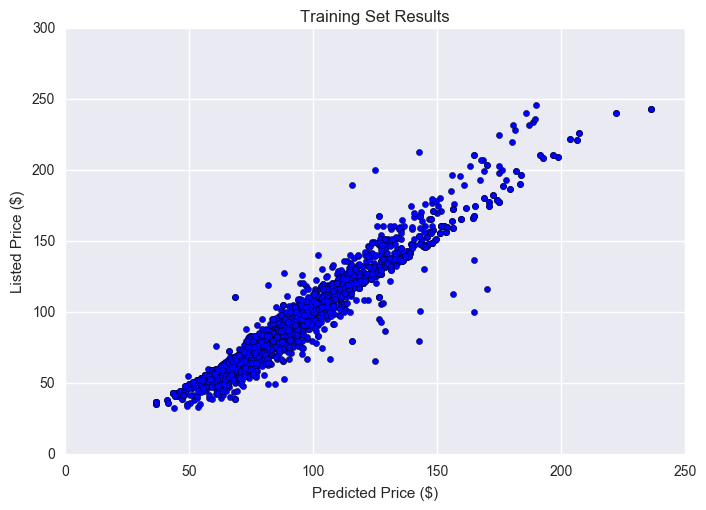

In [47]:
X = np.array(df_train[features_20])
Y = np.array(df_train['corr_price'].astype('float'))
forest=RandomForestRegressor(n_estimators=1000,max_features='log2',n_jobs=-1)
forest.fit(X,Y)
df['pred_price']=forest.predict(df[features_20])
plt.scatter(df.ix[train_rows]['pred_price'],df.ix[train_rows]['corr_price'])
plt.title('Training Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

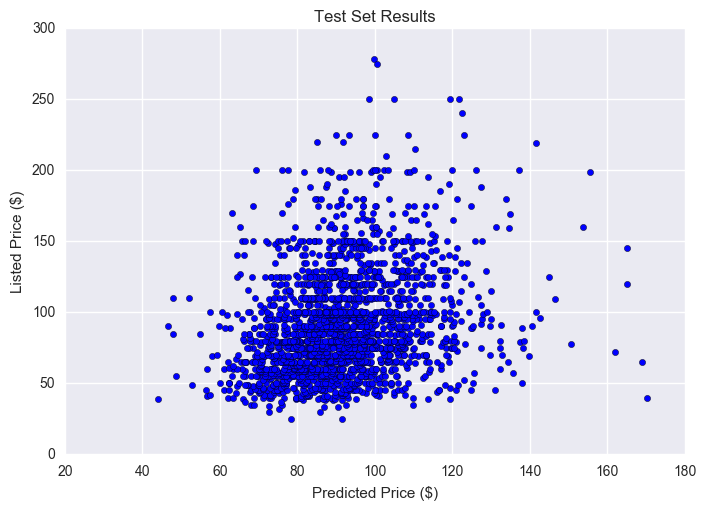

In [48]:
plt.scatter(df.drop(train_rows)['pred_price'],df.drop(train_rows)['price'])
plt.title('Test Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

In [50]:
#fit line to test set
x=df.drop(train_rows)['pred_price']
y=df.drop(train_rows)['corr_price']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(slope,intercept,r_value**2,p_value,std_err)

0.614723715749 35.5590381049 0.0885601042222 3.91453325639e-43 0.0436092150917


In [55]:
df[df.corr_price > 2.5*df.pred_price]

acc_rating amen_1 amen_10 amen_11 amen_12 amen_13 amen_14 amen_15  \
12967003        10.0  False   False   False   False   False   False   False   
8237402         10.0  False   False   False   False   False   False   False   
6731942         10.0  False   False   False   False   False   False    True   
15099424        10.0  False   False   False   False   False   False   False   

         amen_16 amen_17    ...     bin_num_bathrooms  \
12967003   False   False    ...                  True   
8237402    False    True    ...                  True   
6731942    False    True    ...                  True   
15099424   False   False    ...                  True   

         bin_communication_rating bin_value_rating bin_person_cap  \
12967003                     True             True          False   
8237402                      True             True           True   
6731942                      True             True           True   
15099424                     True             True           True   

         bin_review_count bin_is_apt bin_instant_book dist_ferry_quant  \
12967003            False       True            False   (0.129, 0.138]   
8237402             False      False            False   (0.129, 0.138]   
6731942             False      False            False   (0.129, 0.138]   
15099424            False      False            False  (0.0886, 0.105]   

          corr_price pred_price  
12967003  181.921757  64.520863  
8237402   194.916169  71.784276  
6731942   244.294931  87.321626  
15099424  243.492688  85.140690  

[4 rows x 107 columns]

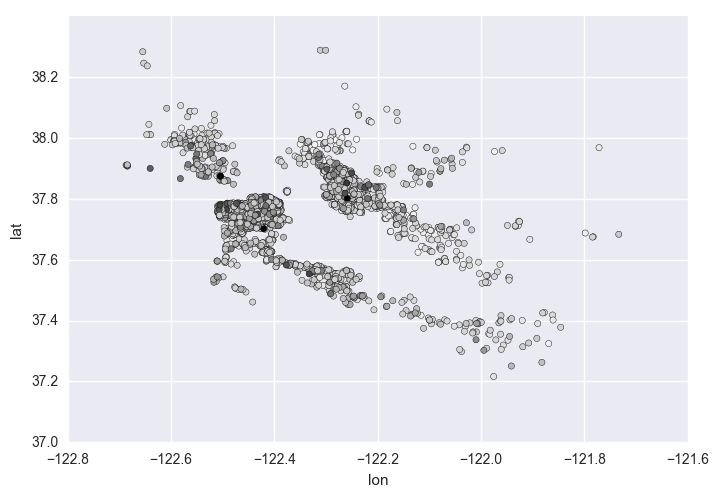

In [61]:
df.plot(x='lon',y='lat',kind='scatter',c=(df['corr_price']-df['pred_price'])/df['pred_price']);

In [63]:
df['pred_error'] = (df['pred_price']-df['corr_price'])/df['corr_price']

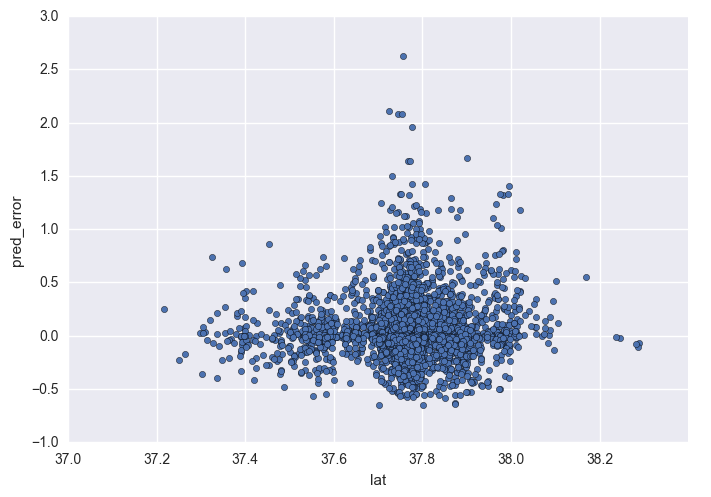

In [67]:
df.plot(x='lat',y='pred_error',kind='scatter');

2245

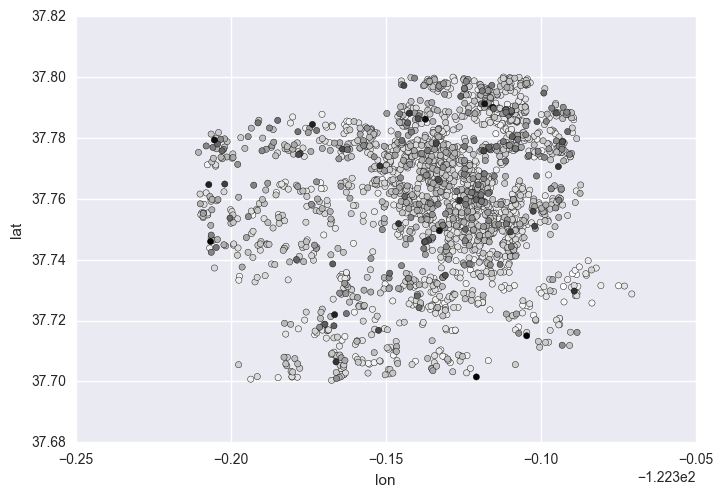

In [91]:
df_SF = df[df.lat<37.8]
df_SF = df_SF[df_SF.lat>37.7]
df_SF = df_SF[df_SF.lon<-122.3]
M_train = int(len(df.index)*0.75)
train_rows = np.random.choice(df.index.values,M_train)
df_train = df.ix[train_rows]
df_test = df.drop(train_rows)df_SF.plot(x='lon',y='lat',kind='scatter',c=df_SF['corr_price']/55)
len(df_SF.index)

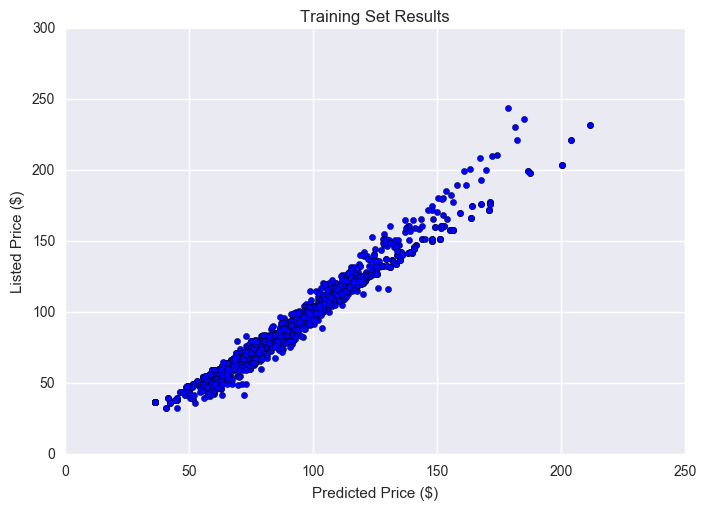

In [93]:
M_train = int(len(df_SF.index)*0.8)
train_rows = np.random.choice(df_SF.index.values,M_train)
df_train = df.ix[train_rows]
df_test = df.drop(train_rows)

X = np.array(df_train[featureList])
Y = np.array(df_train['corr_price'].astype('float'))
forest=RandomForestRegressor(n_estimators=1000,max_features='log2',n_jobs=-1)
forest.fit(X,Y)
df_SF['pred_price']=forest.predict(df_SF[featureList])
plt.scatter(df_SF.ix[train_rows]['pred_price'],df_SF.ix[train_rows]['corr_price'])
plt.title('Training Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

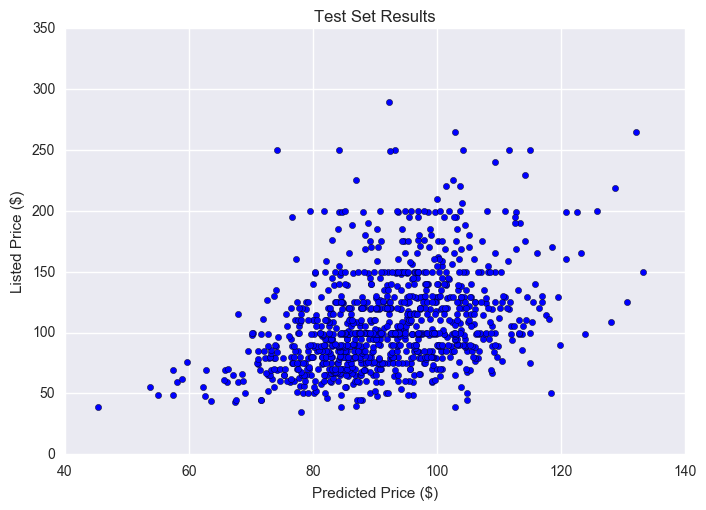

In [94]:
plt.scatter(df_SF.drop(train_rows)['pred_price'],df_SF.drop(train_rows)['price'])
plt.title('Test Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

In [95]:
x=df_SF.drop(train_rows)['pred_price']
y=df_SF.drop(train_rows)['corr_price']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(slope,intercept,r_value**2,p_value,std_err)

1.1669212558 -14.1059827831 0.180274192229 9.92329401594e-45 0.0790446077265


Feature ranking:
1. bin_num_beds (0.044334)
2. bin_guest_sat (0.033457)
3. bin_person_cap (0.032051)
4. bin_is_apt (0.028360)
5. bin_host_other_rev_count (0.025107)
6. amen_2 (0.024902)
7. amen_31 (0.024297)
8. bin_instant_book (0.024005)
9. bin_cleanliness_rating (0.023478)
10. amen_36 (0.023076)
11. amen_1 (0.022839)
12. bin_cancel_policy (0.022810)
13. bin_loc_rating (0.022678)
14. amen_50 (0.021758)
15. amen_37 (0.021676)
16. amen_42 (0.021589)
17. amen_41 (0.021245)
18. amen_3 (0.020491)
19. amen_9 (0.020246)
20. amen_47 (0.020034)
21. amen_49 (0.020024)
22. amen_44 (0.019971)
23. bin_value_rating (0.019817)
24. amen_39 (0.019639)
25. bin_review_count (0.018414)
26. amen_46 (0.018302)
27. bin_acc_rating (0.018272)
28. amen_43 (0.018270)
29. amen_45 (0.017987)
30. amen_8 (0.017966)
31. amen_34 (0.017942)
32. amen_38 (0.017749)
33. amen_30 (0.017319)
34. amen_28 (0.017170)
35. amen_33 (0.016816)
36. amen_16 (0.016670)
37. amen_17 (0.015478)
38. amen_40 (0.015309)
39. amen_27 (0.0148

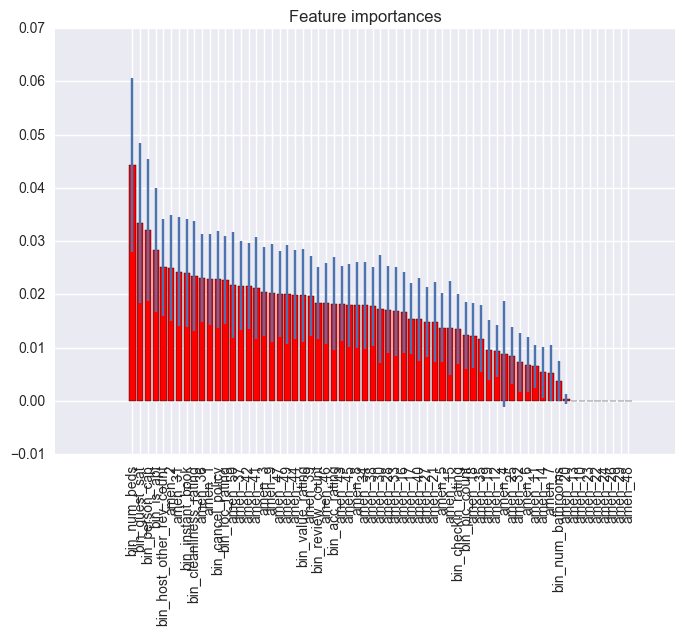

In [96]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#num_feat=20
#indices=indices[:num_feat]
# Print the feature ranking
print("Feature ranking:")
importance_dict = {}
for f in range(X.shape[1]):
    print("%i. %s (%f)" % (f+1,featureList[indices[f]], importances[indices[f]]))
    importance_dict[featureList[indices[f]]] = importances[indices[f]]
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
      color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [featureList[i] for i in indices],rotation=90)
plt.show()

In [107]:
df.groupby('bin_num_beds').mean()['corr_price'][False]

89.947287868495224

In [143]:
derivs = {}
for feature in featureList:
    foo = df.groupby(feature).mean()['corr_price']
    bar = df.groupby(feature).count()['corr_price']
    if len(foo.index) == 2:
        if bar[True] > 1500 and bar[False] > 1500:
            derivs[feature] = abs(foo[True]-foo[False])/foo[False]

In [144]:
feat_names = []
feat_deriv = []
for key in sorted(derivs,key=derivs.get,reverse=True):
    feat_names.append(key)
    feat_deriv.append(derivs[key])
    print(key,derivs[key])

bin_loc_rating 0.163234151922
bin_cleanliness_rating 0.156229988445
bin_guest_sat 0.152472404266
amen_1 0.0798486844007
bin_value_rating 0.0741869842017
bin_host_other_rev_count 0.0741693399771
amen_31 0.069790126676
amen_50 0.0596118724503
amen_49 0.0576093418939
amen_37 0.0509965279352
amen_36 0.0462313773691
amen_9 0.0400791101915
amen_45 0.0355627434226
amen_39 0.0257934433949
amen_46 0.0214012091711
amen_47 0.00776961574012
amen_44 0.00142586644922


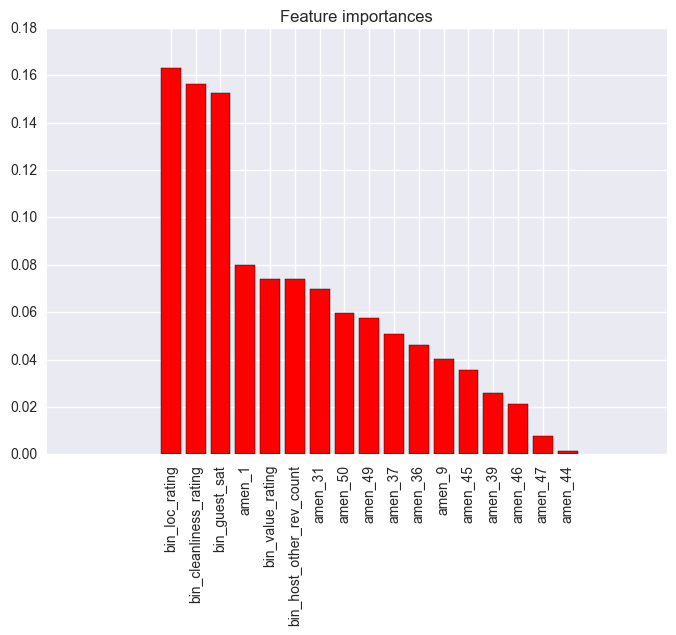

In [145]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feat_names)), feat_deriv,
      color="r", align="center")
plt.xticks(range(len(feat_names)), feat_names,rotation=90)
plt.show()

In [139]:
amen_name_dict = joblib.load('static/amen_name_dict.pkl')
pprint.pprint(amen_name_dict)

{1: 'TV',
 2: 'Cable TV',
 3: 'Internet',
 4: 'Wireless Internet',
 5: 'Air conditioning',
 6: 'Wheelchair accessible',
 7: 'Pool',
 8: 'Kitchen',
 9: 'Free parking on premises',
 10: 'Paid parking off premises',
 11: 'Smoking allowed',
 12: 'Pets allowed',
 14: 'Doorman',
 15: 'Gym',
 16: 'Breakfast',
 21: 'Elevator in building',
 23: 'Free parking on street',
 25: 'Hot tub',
 27: 'Indoor fireplace',
 28: 'Buzzer/wireless intercom',
 30: 'Heating',
 31: 'Family/kid friendly',
 32: 'Suitable for events',
 33: 'Washer',
 34: 'Dryer',
 35: 'Smoke detector',
 36: 'Carbon monoxide detector',
 37: 'First aid kit',
 38: 'Safety card',
 39: 'Fire extinguisher',
 40: 'Essentials',
 41: 'Shampoo',
 42: 'Lock on bedroom door',
 43: '24-hour check-in',
 44: 'Hangers',
 45: 'Hair dryer',
 46: 'Iron',
 47: 'Laptop friendly workspace',
 56: 'Private living room',
 57: 'Private entrance'}


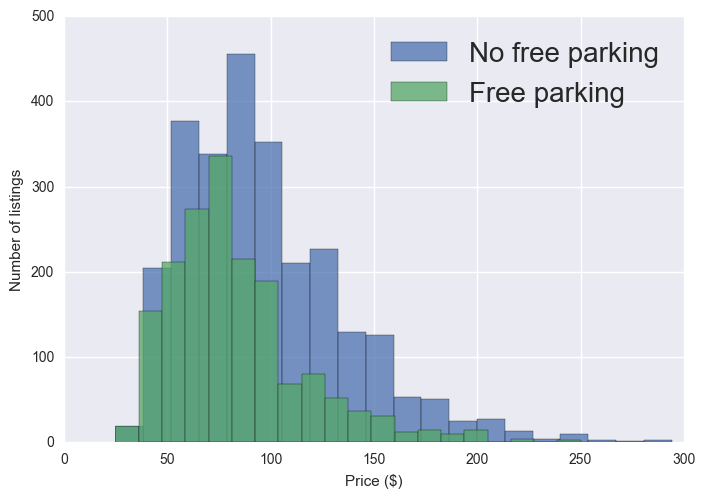

In [76]:
groups = df.groupby('amen_9')['price']
fig,ax=plt.subplots()
for k, v in groups:
    v.hist(label=str(k), alpha=.75, ax=ax,bins=20)
ax.legend()

leg=plt.legend()
leg.get_texts()[0].set_text('No free parking')
leg.get_texts()[1].set_text('Free parking')

plt.xlabel('Price ($)')
plt.ylabel('Number of listings')
params = {'axes.titlesize':40}
plt.rcParams.update(params)

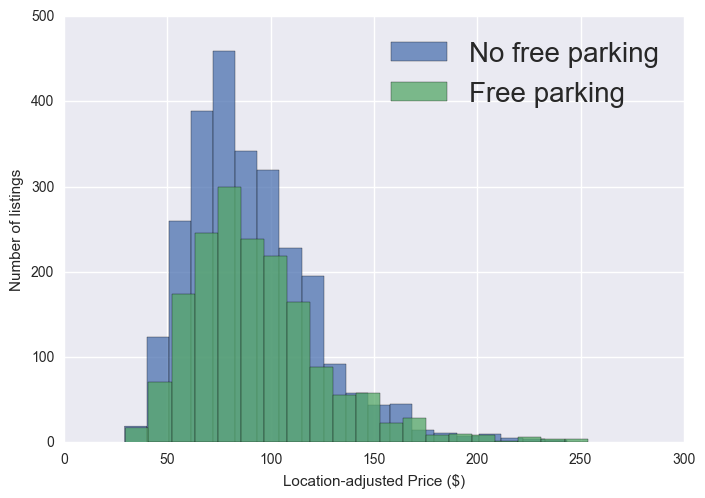

In [80]:
groups = df.groupby('amen_9')['corr_price']
fig,ax=plt.subplots()

for k, v in groups:
    v.hist(label=str(k), alpha=.75, ax=ax,bins=20)

ax.legend()
leg=plt.legend()

leg.get_texts()[0].set_text('No free parking')
leg.get_texts()[1].set_text('Free parking')
plt.xlabel('Location-adjusted Price ($)')
plt.ylabel('Number of listings')

params = {'axes.labelsize':'large'}
plt.rcParams.update(params)

In [52]:
df.groupby('amen_9').mean()[['price','corr_price']]

price  corr_price
amen_9                       
False   97.428843   90.371478
True    83.247972   93.993486

In [54]:
(93.99-90.37)/90.37

0.04005754121943112

In [55]:
(83.25-97.43)/97.43

-0.14554038797085092